In [1]:
import Template
Template = Template.Template()

# Problema:
1) considera un cilindro vertical cuyo eje está centrado en el origen y su radio sea el eje z
2) toma una secuencia de 50 puntos equidistantes en el círculo unitario
3) considera una elipse que yace sobre el cilindro y que no corte el circulo y una secuencia de 50 puntos mas o menos equidistantes
4) escoge los puntos en el circulo y en la elipse de manera que ambas secuencias empiecen en dos puntos cercanos

**a)** Escibe un programa que triangule la parte del cilindro que se encuentra entre el circulo y la elipse. 


**b)** Podrías generalizar tu programa para triangular una cinta cuyos bordes sean dos curvas cerradas en 3D que no se cortan?

## 1. Análisis del Problema

**Objetivo:** Generar una superficie que conecte suavemente una circunferencia situada en el plano z = 0 con una elipse proyectada sobre el mismo cilindro a una altura superior, utilizando para ello una malla continua de triángulos.

**Geometría:**

1. **Cilindro:** Ecuación \(x^2 + y^2 = 1\) (cilindro circular de radio unitario).
2. **Circunferencia base:** Conjunto de puntos \(P_i = (\cos \theta_i, \sin \theta_i, 0)\), uniformemente distribuidos en el plano z = 0.
3. **Elipse superior:** Resulta de la intersección del cilindro con un plano inclinado. Los puntos correspondientes se definen como \(Q_i = (\cos \theta_i, \sin \theta_i, Z(\theta_i))\), donde la función \(Z(\theta_i)\) describe la altura del plano inclinado (por ejemplo, \(z = h + a\cdot x + b\cdot y\)), asegurándonos de que esta curva no intersecte la circunferencia base.

**Algoritmo de Triangulación (Triangle Strip):**

Al disponer del mismo número de puntos en ambas curvas (N = 50) y estar perfectamente alineados angularmente (es decir, cada \(P_i\) tiene su correspondiente \(Q_i\) en la misma dirección radial), la forma más natural y eficiente de mallar la superficie es mediante una triangulación en "cremallera" o strip continua:

Para cada índice i (de 0 a N-1):

- Se genera el triángulo inferior: \(\{$P_i, P_{i+1}, Q_i$\}\)
- Se genera el triángulo superior: \(\{$Q_i, P_{i+1}, Q_{i+1}$\}\)

*Nota: El índice se maneja de forma circular (módulo N), de modo que cuando i = N-1, el siguiente punto i+1 corresponde al punto 0. Esto cierra la superficie sin discontinuidades.*


## 2\. Implementación en Python

Primero, importamos las librerías necesarias y generamos los datos sintéticos para el problema específico (inciso a).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Configuración para gráficos estéticos
plt.style.use('seaborn-v0_8-whitegrid')

# --- PARÁMETROS ---
N = 50  # Número de puntos
r = 1.0 # Radio del cilindro

# 1. Generar ángulos (theta)
# Usamos linspace de 0 a 2pi. Nota: endpoint=False para no repetir el último punto 
# y facilitar la aritmética modular, o lo manejamos manualmente al cerrar el ciclo.
theta = np.linspace(0, 2*np.pi, N, endpoint=False)

# 2. Definir el Círculo Unitario (Base) en z=0
# Puntos P: (x, y, 0)
Px = r * np.cos(theta)
Py = r * np.sin(theta)
Pz = np.zeros_like(theta)
points_circle = np.column_stack((Px, Py, Pz))

# 3. Definir la Elipse sobre el cilindro
# Para que sea una elipse sobre el cilindro, x e y siguen siendo cos/sin, 
# pero z varía según un plano inclinado: z = h + Ax + By
h_offset = 3.0 # Altura media
tilt_x = 0.5   # Inclinación en x
tilt_y = 0.3   # Inclinación en y

Qx = r * np.cos(theta)
Qy = r * np.sin(theta)
Qz = h_offset + tilt_x * Qx + tilt_y * Qy
points_ellipse = np.column_stack((Qx, Qy, Qz))

# Verificación rápida de formas
print(f"Forma del array círculo: {points_circle.shape}")
print(f"Forma del array elipse: {points_ellipse.shape}")

Forma del array círculo: (50, 3)
Forma del array elipse: (50, 3)


## 3. Lógica de Triangulación (a)

En esta parte generamos explícitamente la lista de triángulos que define la conectividad de la malla. 

In [3]:
def generate_triangle_strip(curve1, curve2):
    """
    Genera los índices de los triángulos para conectar dos curvas cerradas
    con el mismo número de vértices.
    
    Args:
        curve1: Array (N, 3) puntos de la curva inferior
        curve2: Array (N, 3) puntos de la curva superior
    
    Returns:
        all_points: Array (2N, 3) con todos los vértices concatenados
        triangles: Array (2N, 3) con los índices de los vértices que forman cada triángulo
    """
    N = len(curve1)
    
    # Concatenamos los puntos para tener una sola lista de vértices
    # Los índices 0 a N-1 son la curva 1
    # Los índices N a 2N-1 son la curva 2
    all_points = np.vstack((curve1, curve2))
    
    triangles = []
    
    for i in range(N):
        # Índices actuales y siguientes (con módulo para cerrar el ciclo)
        i_next = (i + 1) % N
        
        # Índices en la lista combinada
        p1 = i
        p2 = i_next
        q1 = i + N
        q2 = i_next + N
        
        # Triángulo 1: (P_actual, P_siguiente, Q_actual)
        triangles.append([p1, p2, q1])
        
        # Triángulo 2: (P_siguiente, Q_siguiente, Q_actual)
        triangles.append([p2, q2, q1])
        
    return all_points, np.array(triangles)

# Aplicar la función
vertices, tri_indices = generate_triangle_strip(points_circle, points_ellipse)
print(f"Total de triángulos generados: {len(tri_indices)}")

Total de triángulos generados: 100



## 4\. Visualización de la Solución

Graficamos paso a paso: los puntos originales y la superficie reconstruida.

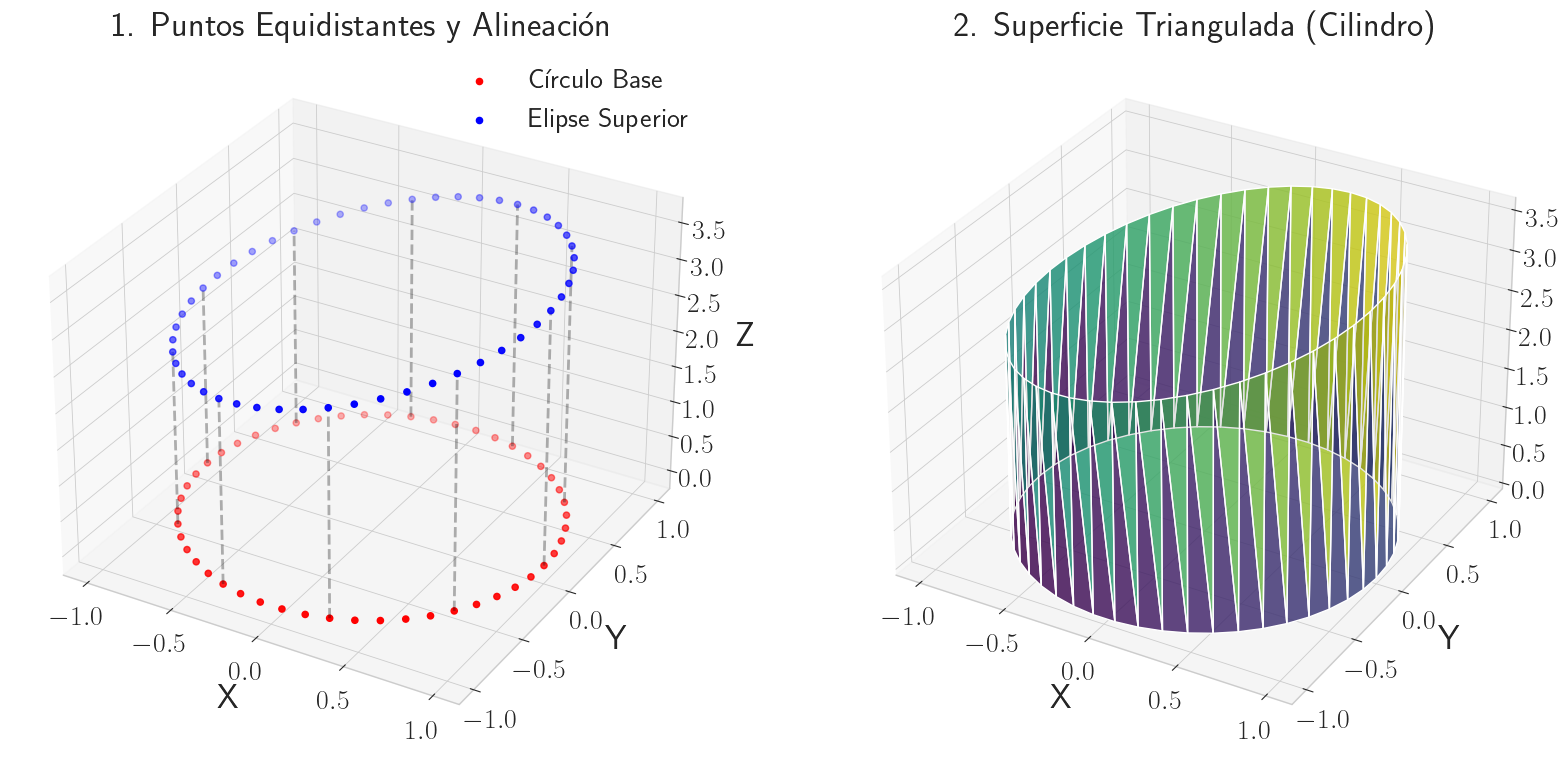

In [4]:
fig = plt.figure(figsize=(17, 8))

# --- GRÁFICA 1: Los Puntos (Nubes de puntos) ---
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(points_circle[:,0], points_circle[:,1], points_circle[:,2], c='red', label='Círculo Base')
ax1.scatter(points_ellipse[:,0], points_ellipse[:,1], points_ellipse[:,2], c='blue', label='Elipse Superior')

# Dibujar líneas verticales para mostrar la correspondencia (opcional, ayuda visual)
for i in range(0, N, 5): # Solo cada 5 puntos para no saturar
    ax1.plot([points_circle[i,0], points_ellipse[i,0]],
             [points_circle[i,1], points_ellipse[i,1]],
             [points_circle[i,2], points_ellipse[i,2]], 'k--', alpha=0.3)

ax1.set_title("1. Puntos Equidistantes y Alineación")
ax1.set_xlabel('X', labelpad=10)
ax1.set_ylabel('Y', labelpad=10)
ax1.set_zlabel('Z', labelpad=10)
ax1.legend()

# --- GRÁFICA 2: La Triangulación (Superficie) ---
ax2 = fig.add_subplot(122, projection='3d')

# Usamos plot_trisurf pasando los triángulos explícitos
# X, Y, Z son arrays planos de todos los vértices
ax2.plot_trisurf(vertices[:,0], vertices[:,1], vertices[:,2], 
                 triangles=tri_indices, 
                 cmap='viridis', edgecolor='none', alpha=0.8)

# Añadimos wireframe (malla) encima para ver los triángulos
ax2.plot_trisurf(vertices[:,0], vertices[:,1], vertices[:,2], 
                 triangles=tri_indices, 
                 color='k', alpha=0.1) # Malla negra tenue

ax2.set_title("2. Superficie Triangulada (Cilindro)")
ax2.set_xlabel('X', labelpad=10)
ax2.set_ylabel('Y', labelpad = 10)
ax2.set_zlabel('Z', labelpad=10)

plt.tight_layout()
plt.show()

## 5. Generalización (b)

### Análisis de la Generalización

La función `generate_triangle_strip` que implementamos anteriormente ya es muy cercana a una solución verdaderamente general, pero aún depende de dos suposiciones implícitas:

1. Ambas curvas están discretizadas con el **mismo número exacto de puntos** (N idéntico).
2. Los puntos están razonablemente **alineados en fase**, es decir, el punto inicial de la curva A se corresponde espacialmente (está “cerca”) del punto inicial de la curva B.

Cuando estas condiciones no se cumplen especialmente la segunda, la malla resultante puede presentar torsiones (“twist”), lo que la hace visualmente inaceptable aunque topológicamente correcta.

**Algoritmo Generalizado Propuesto:**

1. Recibir las dos curvas como listas de puntos 3D: `curva_A` y `curva_B`.

2. Verificar que tengan el mismo número de puntos. Si no es así, remuestrear (interpolar) la curva con menor resolución hasta igualar N con la otra. (Este paso es obligatorio para poder aplicar la triangulación en cremallera).

3.  **Alineación de fase automática:**  
    Utilizar como referencia el punto 0 de `curva_A` y determinar la distancia euclidiana entre este punto y **cada uno** de los puntos de `curva_B`.  El nuevo punto de partida óptimo será el índice de `curva_B` que reduzca al mínimo esa distancia.  Ahora, giramos `curva_B` de manera cíclica para que ese punto se convierta en el índice 0.  
    Esta simple técnica elimina casi por completo el giro, incluso en curvas muy desalineadas.

4. Cuando ambas curvas hayan sido alineadas correctamente en fase y tengan la misma cantidad de puntos, ejecutar el mismo procedimiento de triangulación en cremallera que se explicó en las secciones anteriores.

Con estas tres etapas adicionales, la función se convierte en universal para cualquier conjunto de curvas cerradas que no se crucen entre sí en el espacio tridimensional, sin importar su ubicación.

Alineación automática aplicada: Desplazamiento de 45 índices.


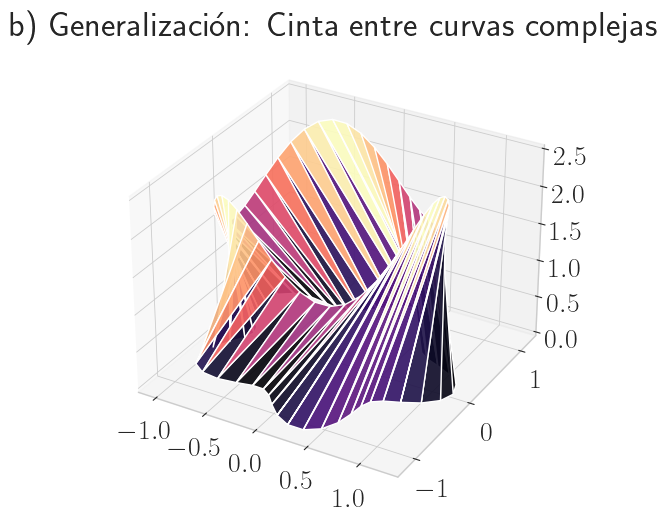

In [5]:
def general_triangulation_ribbon(curve_a, curve_b):
    """
    Generalización para triangular una cinta entre dos curvas 3D cerradas cualesquiera.
    Incluye alineación automática de vértices para minimizar la torsión.
    """
    n_a = len(curve_a)
    n_b = len(curve_b)
    
    # Validación simple (en un caso real, haríamos interpolación si son distintos)
    if n_a != n_b:
        raise ValueError(f"Las curvas deben tener el mismo número de puntos. A={n_a}, B={n_b}")
    
    # Alineación Automática
    # Encontramos qué índice de B está más cerca del índice 0 de A
    # para alinear el "inicio" de la cinta.
    p0 = curve_a[0]
    distances = np.linalg.norm(curve_b - p0, axis=1)
    best_shift = np.argmin(distances)
    
    # Reordenamos (roll) la curva B para que empiece en el punto más cercano a A[0]
    curve_b_aligned = np.roll(curve_b, -best_shift, axis=0)
    
    print(f"Alineación automática aplicada: Desplazamiento de {best_shift} índices.")
    
    # Usamos la lógica de triangulación anterior
    vertices, triangles = generate_triangle_strip(curve_a, curve_b_aligned)
    
    return vertices, triangles

#PRUEBA
# Creemos dos curvas (Toroide deforme o nudos simples)
t = np.linspace(0, 2*np.pi, 50, endpoint=False)

# Curva 1: Un círculo ondulado en el plano
c1_x = (1 + 0.2*np.cos(5*t)) * np.cos(t)
c1_y = (1 + 0.2*np.cos(5*t)) * np.sin(t)
c1_z = np.zeros_like(t)
curve1 = np.column_stack((c1_x, c1_y, c1_z))

# Curva 2: Un círculo desplazado y rotado (desalineado intencionalmente)
c2_x = 1.0 * np.cos(t + np.pi/2) # Nota el desfase de fase (pi/2)
c2_y = 1.0 * np.sin(t + np.pi/2)
c2_z = 2.0 + 0.5*np.sin(3*t)
curve2 = np.column_stack((c2_x, c2_y, c2_z))

# Ejecutar generalización
verts_gen, tris_gen = general_triangulation_ribbon(curve1, curve2)

# Graficar resultado general
fig2 = plt.figure(figsize=(8, 6))
ax_gen = fig2.add_subplot(111, projection='3d')
ax_gen.plot_trisurf(verts_gen[:,0], verts_gen[:,1], verts_gen[:,2], 
                    triangles=tris_gen, cmap='magma', alpha=0.9)
ax_gen.set_title("b) Generalización: Cinta entre curvas complejas")
plt.show()

## 6. Graficas Interactivas con Plotly

In [ ]:
import numpy as np
import plotly.graph_objects as go

def plot_interactive_dual_color(curve_a, curve_b, title="Malla Bicolor"):
    """
    Genera una visualización interactiva donde los triángulos alternan de color
    para revelar la estructura de la malla (Triangle Strip).
    """
    N = len(curve_a)
    
    # --- 1. Alineación Automática (Mejor ajuste) ---
    p0 = curve_a[0]
    distances = np.linalg.norm(curve_b - p0, axis=1)
    best_shift = np.argmin(distances)
    curve_b_aligned = np.roll(curve_b, -best_shift, axis=0)
    
    # --- 2. Preparar Vértices ---
    vertices = np.vstack((curve_a, curve_b_aligned))
    
    # --- 3. Generar Triángulos y Colores ---
    I, J, K = [], [], []
    face_colors = [] 
    
    # Color 1: Golden Orange
    c1 = 'rgba(255, 165, 0, 1)'   # Orange
    # Color 2: Teal
    c2 = 'rgba(0, 206, 209, 1)'   # Dark Turquoise 
    
    for i in range(N):
        next_i = (i + 1) % N
        
        # Índices
        p_curr, p_next = i, next_i
        q_curr, q_next = i + N, next_i + N
        
        # --- Triángulo 1 (Inferior) ---
        I.append(p_curr); J.append(p_next); K.append(q_curr)
        face_colors.append(c1) # Asignar Color 1
        
        # --- Triángulo 2 (Superior) ---
        I.append(p_next); J.append(q_next); K.append(q_curr)
        face_colors.append(c2) # Asignar Color 2

    # --- 4. Crear Gráfico ---
    mesh = go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=I, j=J, k=K,
        facecolor=face_colors,
        opacity=1.0,
        name='Superficie',
        lightposition=dict(x=100, y=200, z=150) # Iluminación mejorada
    )
    
    # Líneas de borde para referencia
    line_a = go.Scatter3d(x=curve_a[:,0], y=curve_a[:,1], z=curve_a[:,2], 
                          mode='lines', line=dict(color='black', width=3), name='Curva A')
    
    b_plot = np.vstack([curve_b_aligned, curve_b_aligned[0]]) # Cerrar visualmente
    line_b = go.Scatter3d(x=b_plot[:,0], y=b_plot[:,1], z=b_plot[:,2], 
                          mode='lines', line=dict(color='black', width=3), name='Curva B')

    fig = go.Figure(data=[mesh, line_a, line_b])
    
    fig.update_layout(
        title=title,
        scene=dict(aspectmode='data'),
        width=800, height=600,
        margin=dict(l=0, r=0, b=0, t=40)
    )
    fig.show()

In [13]:
# Generación de datos
N = 40 # Menos puntos para ver mejor los triángulos individuales
t = np.linspace(0, 2*np.pi, N, endpoint=False)

# Círculo base
c1 = np.column_stack((np.cos(t), np.sin(t), np.zeros_like(t)))

# Elipse inclinada
z_ellipse = 3 + 0.5*np.cos(t) + 0.5*np.sin(t)
c2 = np.column_stack((np.cos(t), np.sin(t), z_ellipse))

plot_interactive_dual_color(c1, c2, "Visualización Bicolor: Cilindro Triangulado")

In [14]:
N = 60
t = np.linspace(0, 4*np.pi, N, endpoint=False) # 2 vueltas

# Curva A: Espiral cónica inversa
r_spiral = np.linspace(0.1, 2.0, N)
ax = r_spiral * np.cos(t)
ay = r_spiral * np.sin(t)
az = np.zeros_like(t)
curve_tornado_base = np.column_stack((ax, ay, az))

# Curva B: Círculo grande flotando arriba
bx = 2.5 * np.cos(t) # Usamos t para mantener sincronía angular
by = 2.5 * np.sin(t)
bz = np.ones_like(t) * 4
curve_top_ring = np.column_stack((bx, by, bz))

plot_interactive_dual_color(curve_tornado_base, curve_top_ring, "Espiral Cónica a Círculo Superior")

In [15]:
N = 80
t = np.linspace(0, 2*np.pi, N, endpoint=False)

# Curva A: Círculo deformado (ovalado en X)
ax = 2.0 * np.cos(t)
ay = 1.0 * np.sin(t)
az = 0.5 * np.sin(3*t) # Pequeña ondulación
curve_mobius_1 = np.column_stack((ax, ay, az))

# Curva B: Círculo deformado (ovalado en Y) y rotado 180 grados en fase
# Al poner '+ np.pi' forzamos a la malla a cruzar todo el diámetro
bx = 1.0 * np.cos(t + np.pi) 
by = 2.0 * np.sin(t + np.pi)
bz = 2.0 + 0.5 * np.cos(3*t)
curve_mobius_2 = np.column_stack((bx, by, bz))

plot_interactive_dual_color(curve_mobius_1, curve_mobius_2, "Cinta Cruzada (Twisted)")